In [1]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import (
    SentenceTransformersDocumentEmbedder,
    SentenceTransformersTextEmbedder,
)
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

# Preparation

### Setup the environment
**Using UV** 
1. `uv sync`
1. uv run jupyter lab notebooks/rag_pipeline.ipynb

**Using Pip**
1. install a python 3.12 environment using venv or conda e.g. `conda create -n environment-name python=3.12`
1. activate the environment, e.g. `conda activate environment-name`
1. `pip install -r requirements.txt`
1. `jupyter lab notebooks/rag_pipeline.ipynb`

### Setup the OpenAI API key
1. rename `.env.example` to `.env` and **add your API key for OpenAI to the .env file using OPENAI_API_KEY=sk-...**


### Run the notebook

3. "Run All!"

## Ensure the OpenAI API key is set

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import getpass
import os

# Try to get the OpenAI API key from environment variables
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

# If the API key is not found in environment variables, prompt the user to enter it
if not OPENAI_API_KEY:
    print("OpenAI API key not found in environment variables.")
    OPENAI_API_KEY = getpass.getpass("Please enter your OpenAI API key: ")
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
else:
    print("Great! OpenAI API Key is Set!")

Great! OpenAI API Key is Set!


## Set Working Directory

In [4]:
import os


# Find the directory containing pyproject.toml by searching upwards from the current directory
def find_project_root(start_dir=os.getcwd()):
    current_dir = start_dir
    while True:
        if "pyproject.toml" in os.listdir(current_dir):
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:  # Reached the root directory
            raise FileNotFoundError(
                "Could not find pyproject.toml in any parent directory."
            )
        current_dir = parent_dir


# Set the working directory to the project root
PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)

In [5]:
# Print the current working directory for confirmation
print("Current working directory:", os.getcwd())

Current working directory: /Users/giladrubin/python_workspace/rag_datanights


### Read the docs or add them to your AI IDE context

https://docs.haystack.deepset.ai/docs/intro

We're good to go!

# Indexing Pipeline

In [6]:
from src.utils import display_pipeline

## Load PDFs

This section handles PDF document conversion using the PyPDFToDocument component.

This component transforms PDF files into Haystack `Document` objects that have `metadata` and `content` attributes. 

For more details, see the [PyPDFToDocument documentation](https://docs.haystack.deepset.ai/docs/pypdftodocument).


In [7]:
import os

filepaths = [
    f"data/raw/{file}" for file in os.listdir("data/raw") if file.endswith(".pdf")
]

In [8]:
indexing_pipeline = Pipeline()

In [9]:
from haystack.components.converters import PyPDFToDocument

pdf_loader = PyPDFToDocument()

In [10]:
indexing_pipeline.add_component("pdf_loader", pdf_loader)

In [11]:
display_pipeline(indexing_pipeline)


```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px', 'edgeLabelBackground': '#ffffff'}}}%%
graph TD;
    pdf_loader["pdf_loader<br><small><i>PyPDFToDocument</i></small>"]
```

Now, let's run the pipeline!

In [12]:
res = indexing_pipeline.run({"pdf_loader": {"sources": filepaths}})

In [13]:
docs = res["pdf_loader"]["documents"]

In [14]:
print(f"Content: {docs[0].content[:300]}...")

Content: 1
Modular RAG: Transforming RAG Systems into
LEGO-like Reconfigurable Frameworks
Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang
Abstract—Retrieval-augmented Generation (RAG) has
markedly enhanced the capabilities of Large Language Models
(LLMs) in tackling knowledge-intensive tasks. The increasing
de...


In [15]:
print(f"Metadata: {docs[0].meta}")

Metadata: {'file_path': 'modular_rag.pdf'}


## Split Documents

This section handles document splitting, which divides documents into smaller chunks. 

`DocumentSplitter` expects a list of documents as input and returns a list of documents with split texts. It splits each input document by `split_by` after `split_length` units with an overlap of `split_overlap` units. These additional parameters can be set when the component is initialized:

  * `split_by` can be `"word"`, `"sentence"`, `"passage"` (paragraph), `"page"`, `"line"` or `"function"`. 
  * `split_length` is an integer indicating the chunk size, which is the number of words, sentences, or passages.
  * `split_overlap` is an integer indicating the number of overlapping words, sentences, or passages between chunks.
  * `split_threshold` is an integer indicating the minimum number of words, sentences, or passages that the document fragment should have. If the fragment is below the threshold, it will be attached to the previous one.

A field `"source_id"` is added to each document's `meta` data to keep track of the original document that was split. Another meta field `"page_number"` is added to each document to keep track of the page it belonged to in the original document. Other metadata are copied from the original document.

For more details, see the [DocumentSplitter documentation](https://docs.haystack.deepset.ai/docs/documentsplitter).

In [16]:
from haystack.components.preprocessors import DocumentSplitter

In [17]:
splitter = DocumentSplitter(
    split_by="line",
    split_length=12,
    split_overlap=3,
)

In [18]:
indexing_pipeline.add_component("splitter", splitter)

In [19]:
indexing_pipeline.connect("pdf_loader", "splitter")

🚅 Components
  - pdf_loader: PyPDFToDocument
  - splitter: DocumentSplitter
🛤️ Connections
  - pdf_loader.documents -> splitter.documents (List[Document])

In [20]:
display_pipeline(indexing_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px', 'edgeLabelBackground': '#ffffff'}}}%%
graph TD;
    pdf_loader["pdf_loader<br><small><i>PyPDFToDocument</i></small>"]
    splitter["splitter<br><small><i>DocumentSplitter</i></small>"]
    pdf_loader ==> splitter
```

In [21]:
res = indexing_pipeline.run({"pdf_loader": {"sources": filepaths}})
docs = res["splitter"]["documents"]

In [22]:
print(f"Content: {docs[1].content}")

Content: LLMs and other complementary technologies, which in turn
has amplified the intricacy of RAG systems. However, the rapid
advancements are outpacing the foundational RAG paradigm,
with many methods struggling to be unified under the process
of “retrieve-then-generate”. In this context, this paper examines
the limitations of the existing RAG paradigm and introduces
the modular RAG framework. By decomposing complex RAG
systems into independent modules and specialized operators, it
facilitates a highly reconfigurable framework. Modular RAG
transcends the traditional linear architecture, embracing a
more advanced design that integrates routing, scheduling, and
fusion mechanisms. Drawing on extensive research, this paper



In [23]:
from pprint import pprint

print("Metadata:")
pprint(docs[1].meta)

Metadata:
{'_split_overlap': [{'doc_id': 'b40b48303f1c7971303fe8a12d4ffb0246f6fdc95541d7c4f0f2966ce28300ae',
                     'range': (416, 594)},
                    {'doc_id': '4cfecdfb41c80da4b0930be22ee7fe4405d592d1cfd14dad7c3ef6f38aaaeac1',
                     'range': (0, 183)}],
 'file_path': 'modular_rag.pdf',
 'page_number': 1,
 'source_id': 'b7efb3adbf662bf46a2176b4196e18cddce2ac7c733bea7f2264e184c7714d97',
 'split_id': 1,
 'split_idx_start': 416}


## Embed Chunks

In [24]:
embed_model = "sentence-transformers/all-MiniLM-L6-v2"

In [25]:
doc_embedder = SentenceTransformersDocumentEmbedder(model=embed_model, batch_size=16)
indexing_pipeline.add_component("doc_embedder", doc_embedder)

In [26]:
indexing_pipeline.connect("splitter", "doc_embedder")

🚅 Components
  - pdf_loader: PyPDFToDocument
  - splitter: DocumentSplitter
  - doc_embedder: SentenceTransformersDocumentEmbedder
🛤️ Connections
  - pdf_loader.documents -> splitter.documents (List[Document])
  - splitter.documents -> doc_embedder.documents (List[Document])

In [27]:
display_pipeline(indexing_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px', 'edgeLabelBackground': '#ffffff'}}}%%
graph TD;
    pdf_loader["pdf_loader<br><small><i>PyPDFToDocument</i></small>"]
    splitter["splitter<br><small><i>DocumentSplitter</i></small>"]
    doc_embedder["doc_embedder<br><small><i>SentenceTransformersDocumentEmbedder</i></small>"]
    pdf_loader ==> splitter
    splitter ==> doc_embedder
```

In [28]:
indexing_pipeline.warm_up()

In [29]:
res = indexing_pipeline.run({"pdf_loader": {"sources": filepaths}})

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [30]:
docs = res["doc_embedder"]["documents"]

In [31]:
docs[0].embedding[:10]

[-0.08337507396936417,
 -0.025299422442913055,
 0.02456732466816902,
 0.01030047982931137,
 -0.05183596909046173,
 0.061009109020233154,
 -0.011369384825229645,
 -0.017378514632582664,
 -0.0010302533628419042,
 -0.02779301069676876]

## Visualize Embeddings

In [32]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "FALSE"  # This avoids a warning

In [34]:
from src.utils import visualize_document_embeddings

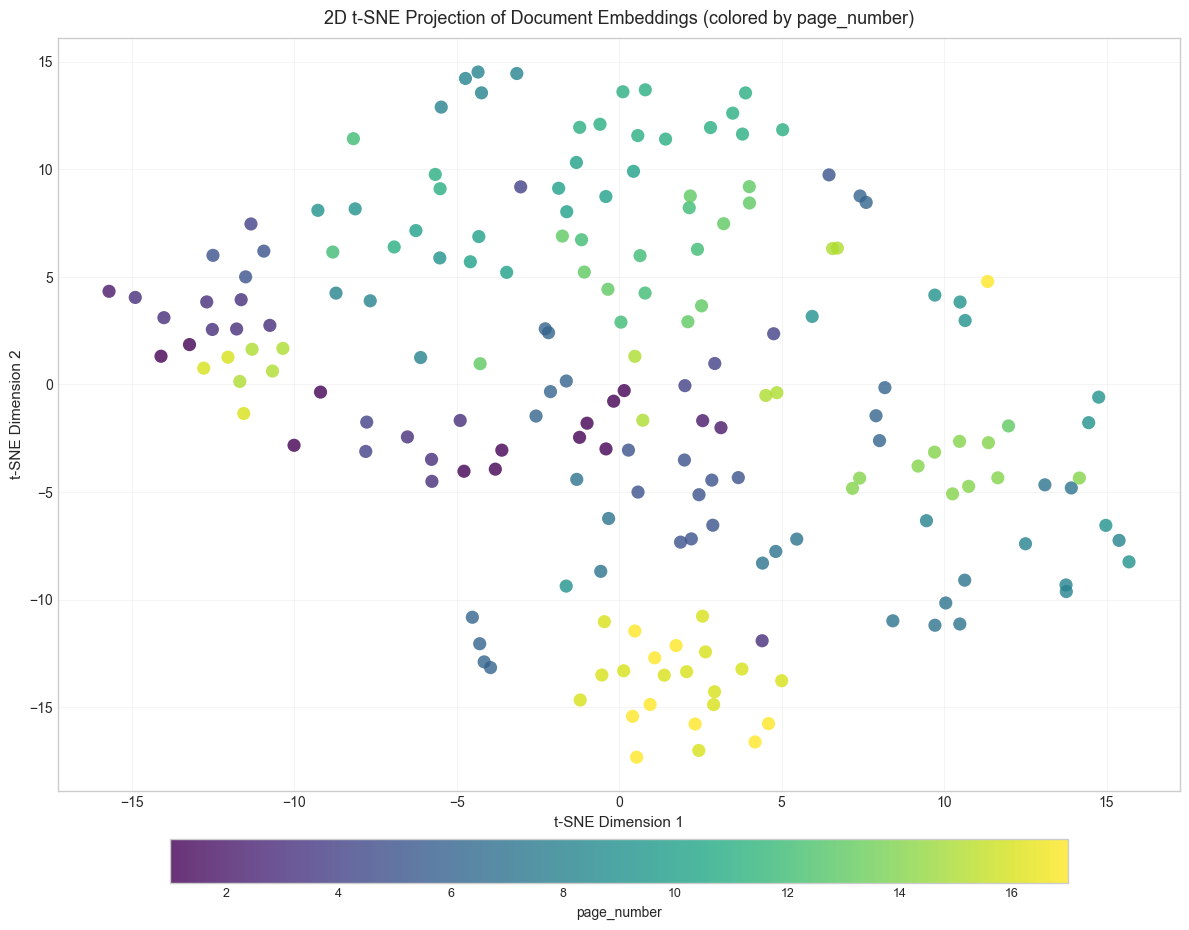

In [35]:
# Get the embedded documents from the previous run
embedded_documents = res["doc_embedder"]["documents"]

# Create the visualization
projection = visualize_document_embeddings(embedded_documents, color_by="page_number")

## Write Chunks to Document Store

In [36]:
document_store = InMemoryDocumentStore()
document_writer = DocumentWriter(document_store, policy=DuplicatePolicy.OVERWRITE)

In [37]:
indexing_pipeline.add_component("document_writer", document_writer)
indexing_pipeline.connect("doc_embedder", "document_writer")

🚅 Components
  - pdf_loader: PyPDFToDocument
  - splitter: DocumentSplitter
  - doc_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - pdf_loader.documents -> splitter.documents (List[Document])
  - splitter.documents -> doc_embedder.documents (List[Document])
  - doc_embedder.documents -> document_writer.documents (List[Document])

In [38]:
display_pipeline(indexing_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px', 'edgeLabelBackground': '#ffffff'}}}%%
graph TD;
    pdf_loader["pdf_loader<br><small><i>PyPDFToDocument</i></small>"]
    splitter["splitter<br><small><i>DocumentSplitter</i></small>"]
    doc_embedder["doc_embedder<br><small><i>SentenceTransformersDocumentEmbedder</i></small>"]
    document_writer["document_writer<br><small><i>DocumentWriter</i></small>"]
    pdf_loader ==> splitter
    splitter ==> doc_embedder
    doc_embedder ==> document_writer
```

In [39]:
indexing_pipeline.run({"pdf_loader": {"sources": filepaths}})

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 187}}

In [40]:
document_store.count_documents()

187

# Retrieval + Generation Pipeline


In [41]:
rag_pipeline = Pipeline()

## Embed Query


In [42]:
query_embedder = SentenceTransformersTextEmbedder(model=embed_model)

In [43]:
rag_pipeline.add_component("query_embedder", query_embedder)

In [44]:
display_pipeline(rag_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px', 'edgeLabelBackground': '#ffffff'}}}%%
graph TD;
    query_embedder["query_embedder<br><small><i>SentenceTransformersTextEmbedder</i></small>"]
```

## Define Retriever


In [45]:
retriever = InMemoryEmbeddingRetriever(document_store, top_k=10)

In [46]:
rag_pipeline.add_component("retriever", retriever)

In [47]:
rag_pipeline.connect("query_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

In [48]:
display_pipeline(rag_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px', 'edgeLabelBackground': '#ffffff'}}}%%
graph TD;
    query_embedder["query_embedder<br><small><i>SentenceTransformersTextEmbedder</i></small>"]
    retriever["retriever<br><small><i>InMemoryEmbeddingRetriever</i></small>"]
    query_embedder ==> retriever
```

## LLM Generation

In [49]:
template = """
Given the following information, answer the question.
Please answer using direct phrases and sentences from the context as possible.

Context:
{% for document in documents %}
    This is the metadata of the document:
    {{ document.meta }}
    ================================
    This is the content of the document:
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

In [50]:
prompt_builder = PromptBuilder(template=template)

In [51]:
rag_pipeline.add_component("prompt_builder", prompt_builder)

In [52]:
generator = OpenAIGenerator(model="gpt-4o-mini")
rag_pipeline.add_component("llm", generator)

In [53]:
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [54]:
display_pipeline(rag_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px', 'edgeLabelBackground': '#ffffff'}}}%%
graph TD;
    query_embedder["query_embedder<br><small><i>SentenceTransformersTextEmbedder</i></small>"]
    retriever["retriever<br><small><i>InMemoryEmbeddingRetriever</i></small>"]
    prompt_builder["prompt_builder<br><small><i>PromptBuilder</i></small>"]
    llm["llm<br><small><i>OpenAIGenerator</i></small>"]
    query_embedder ==> retriever
    retriever ==> prompt_builder
    prompt_builder ==> llm
```

# Query Pipeline

In [72]:
question = "What is Reciprocal Rank Fusion?"

response = rag_pipeline.run(
    {"query_embedder": {"text": question}, "prompt_builder": {"question": question}},
    include_outputs_from=["retriever", "prompt_builder"],
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [73]:
llm_response = response["llm"]["replies"][0]

In [74]:
from src.utils import nicer_print

nicer_print(llm_response)

Reciprocal Rank Fusion (RRF) is "an ensemble technique that synthesizes multiple
retrieval result rankings into a cohesive, unified list." It "employs a tailored
weighted averaging approach to enhance collective predictive performance and
ranking precision." The method’s strength lies in "its dynamic weight
assignment, which is informed by the interplay among branches." RRF is
especially potent "in scenarios characterized by model or source heterogeneity."


## Analyze Results

#### Print the prompt

In [59]:
print(response["prompt_builder"]["prompt"])


Given the following information, answer the question.
Please answer using direct phrases and sentences from the context as possible.

Context:

    This is the metadata of the document:
    {'file_path': 'modular_rag.pdf', 'source_id': 'b7efb3adbf662bf46a2176b4196e18cddce2ac7c733bea7f2264e184c7714d97', 'page_number': 9, 'split_id': 98, 'split_idx_start': 45194, '_split_overlap': [{'doc_id': 'dda63d1d57707ed9f52171434e92a01d46953c0406938e3120f721c60942e178', 'range': (514, 636)}, {'doc_id': 'fa3a58815b6afaf5a7087dea5e64192039e9cc7c94774d952ccdb89ad6a385d3', 'range': (0, 161)}]}
    This is the content of the document:
    process design. A RAG flow pattern can be defined as P =
{Mϕ1 : {Op1} →Mϕ2 : {Op2} →. . .→ Mϕn : {Opn}}
A. Linear Pattern
The modules in the modular RAG system are organized in
a linear way, and can be described as Algorithm 1.
Plinear = {M1 → M2 → . . .→ Mn} (25)10
Fig. 4. Linear RAG flow pattern. Each module is processed in a fixed
sequential order.
Fig. 5. RRR [24

## Explore the document scores

In [102]:
retrieved_documents = response["retriever"]["documents"]

In [103]:
retrieved_documents[0].score

0.6547455627250159

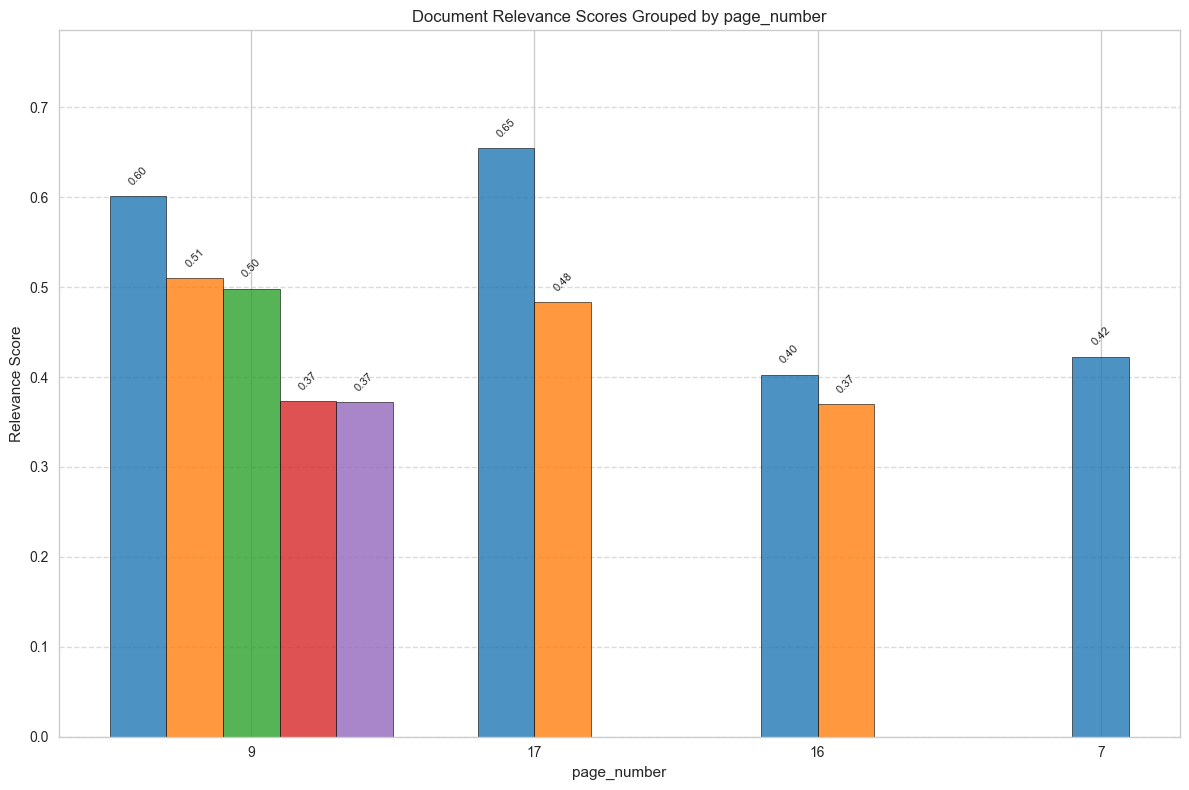


Detailed scores by page_number:


In [105]:
from src.utils import visualize_document_scores

# Visualize the scores of retrieved documents
score_data = visualize_document_scores(
    retrieved_documents, metadata_field="page_number"
)

In [106]:
# Display the top 5 documents with their scores and file paths
print("\nTop 5 Most Relevant Documents:")
display(score_data[["score", "page_number"]].head(5))


Top 5 Most Relevant Documents:


,score,page_number
1,0.601486,9
2,0.510023,9
3,0.498458,9
7,0.373277,9
8,0.372008,9
